In [1]:
# Input info

indir = "/data/Mito_Trace/output/pipeline/v03/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_init/bestparams/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v03/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_multiplex/gff_hg38_1_2/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v03/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/mt_as_clones/results/noInput/af.0.1_othaf.0.1_cov.10_othcov.10_ncells.10_othncells.0.25_mean.0"
N_DONORS = 5
condition = "noInput"

input_cond = "Input"
#condition = "inputOnly" # noInput

atac_col = "cluster_labels"
clone_col = "Variants"

# params
min_clone_size = 2
p_thresh = 0.1 


#conds_sep = False
n_shuffle = 1000
n_cpus = 8


In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sep_dir = join(outdir,"sepDonors")
if not exists(sep_dir):
    os.mkdir(sep_dir)
donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
#     if not exists(join(donor_out[d], "shuffle")):
#         os.mkdir(join(donor_out[d], "shuffle"))

In [5]:
# cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
# cells_meta.head()

In [6]:
bin_d = {}
best_params = pd.read_csv(join(indir,  "best_params.csv"))
for d in range(N_DONORS): 
    bin_d[d] = pd.read_csv(join(indir,  f"donor_{d}_binary.csv"), index_col=0)

labels_df = pd.read_csv(se_cells_meta_f,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()


# def fill_mt_bin(curr_pos, curr_cells):
#     print(curr_pos.name)
#     curr_pos.loc[curr_cells[curr_pos.name]["other_cells"]] = 0
#     curr_pos.loc[curr_cells[curr_pos.name]["clone_cells"]] = 1
#     return curr_pos

# cells_dir=join(indir, "cells")


# bin_d = {}
# for d in range(N_DONORS): 
#     curr_f = join(cells_dir, f"don.{d}_af.{af_t}_othaf.{oth_af_t}_cov.{cov_t}_othcov.{oth_cov_t}.p")
#     curr_cells = pickle.load(open(curr_f,'rb'))
#     params_results = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")    


#     curr_p = params_results.loc[(params_results["af"]==af_t) &
#                        (params_results["oth_af"]==oth_af_t) &
#                        (params_results["cov"]==cov_t) &
#                        (params_results["oth_cov"]==oth_cov_t) &
#                        (params_results["ncells"]==ncells) &
#                        (params_results["oth_ncells"]==oth_ncells) &
#                        (params_results["mean_cov"]==mean_pos_cov)]
#     assert(len(curr_p)==1)
    
#     ## Construct a binary cell-by-variant matrix for the kept variants. 
#     ## Can add N/A if not in oth cells
#     curr_vars = curr_p.iloc[0]["Variants"].split(";")

#     all_cells = set()
#     for x in curr_cells:
#         all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
#         all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 

#     mt_bin = pd.DataFrame(index = all_cells, columns=curr_vars)
#     bin_d[d] = mt_bin.apply(fill_mt_bin, curr_cells=curr_cells,axis=0).fillna(0)



(5860, 41)
(4281, 41)


,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nCount_RNA,nFeature_RNA,Row.names,index,raw.ID,new.index,condition,donor,donor_index,cluster_labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGGAAACTT-1_Input,Input,2831,2831,49701.0,5002,164,92,1138,37812,5493,...,3505,2884,Input_AAACGAAAGGAAACTT-1,0.0,AAACGAAAGGAAACTT-1,1.0,Input,1,1.0,2
AAACGAAGTCCAAGAG-1_Input,Input,4565,4565,62869.0,9096,249,139,1902,42086,9397,...,6161,4469,Input_AAACGAAGTCCAAGAG-1,1.0,AAACGAAGTCCAAGAG-1,2.0,Input,4,1.0,0
AAACGAAGTCCGAGCT-1_Input,Input,7229,7229,60574.0,11583,352,141,2087,31767,14644,...,9778,6201,Input_AAACGAAGTCCGAGCT-1,2.0,AAACGAAGTCCGAGCT-1,3.0,Input,3,1.0,1
AAACGAAGTTTGAAGA-1_Input,Input,7001,7001,68829.0,12010,432,163,2209,39985,14030,...,9266,5942,Input_AAACGAAGTTTGAAGA-1,4.0,AAACGAAGTTTGAAGA-1,5.0,Input,1,2.0,1
AAACGAATCCCAGTAA-1_Input,Input,2103,2103,30056.0,2764,124,63,832,22385,3888,...,2540,2215,Input_AAACGAATCCCAGTAA-1,5.0,AAACGAATCCCAGTAA-1,6.0,Input,0,1.0,2


# Filter for input

In [7]:
if condition == "inputOnly":
    labels_df = labels_df[labels_df["condition"]==input_cond]
elif condition == "noInput":
    labels_df = labels_df[labels_df["condition"]!=input_cond]
else:
    raise ValueError("condition not accurate")
for d in bin_d:
    bin_d[d] = bin_d[d].loc[bin_d[d].index.isin(labels_df.index)]
bin_d[d].head()

,3010A,8860G,4769G,1438G,750G,310C,477C,263G,15326G,16519C,10646A,3106A
GTTACTTTCCTGAAAC-1_Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
CTCACCAGTCAGGCTC-1_Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
TTACTCAGTGGACGAT-1_Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
AATACGCAGCTGAATA-1_Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
TGGAAGGTCGCGTTCT-1_Flt3l,1,1,1,1,1,1,1,1,1,1,1,1


In [8]:
def get_mt_ncells(curr_df, bin_d):
    lab, don = curr_df.name
    curr_bin = bin_d[int(don)]
    out = curr_bin.loc[curr_bin.index.isin(curr_df.index)].sum(axis=0).fillna(0)
    out.name = "count"
    return out #curr_bin.loc[curr_df.index].sum(axis=0)
    
lin_mt_ncells = labels_df.groupby(["cluster_labels", "donor"]).apply(get_mt_ncells, bin_d)
lin_mt_ncells = lin_mt_ncells.reset_index().rename({"level_2":"Variants"}, axis=1)

# convert back to raw cell count from log2
#lin_mt_ncells["count"] = (np.ceil((2**lin_mt_ncells["count"])-1)).astype(int)

In [9]:
pd.merge(labels_df[["donor", "cluster_labels", "condition"]], bin_d[d], 
         left_index=True, right_index=True, how="inner")


,donor,cluster_labels,condition,3010A,8860G,4769G,1438G,750G,310C,477C,263G,15326G,16519C,10646A,3106A
AAATGCCCAGAAAGAG-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
AAGGTTCAGTGCTAGG-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
AATACGCAGCTGAATA-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
AATACGCGTAGTCTGT-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
ACCCAAAGTAGGTAAT-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAGCTTAGGTCGGTA-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
TTCGTTAGTATTCTTC-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
TTGCCCAGTTATAGAG-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1
TTGCGAAAGACCGCAA-1_Flt3l,4,9,Flt3l,1,1,1,1,1,1,1,1,1,1,1,1


['11332T' '11339C' '11467G' '11719A' '12297C' '12308G' '12372A' '1438G'
 '14620T' '14766T' '15326G' '15693C' '15789T' '16356C' '16362C' '16519C'
 '1811G' '195C' '2083C' '263G' '2706G' '2875G' '3106A' '310C' '3144G'
 '3672G' '4646C' '4769G' '499A' '5999C' '6047G' '7028T' '73G' '750G'
 '7705C' '8642G' '8860G']
[ 4  9 12 13]
Running hypergeo and saving sig results
plotting counts


ic| 'global all'


Number of groups below p-val significance: 0


ic| 'global min'


Number of groups below p-val significance: 0


ic| 'clone all'


axs 10
bh shape (37, 4)


ic| 'clone min'


ValueError: Wrong number of items passed 4, placement implies 1

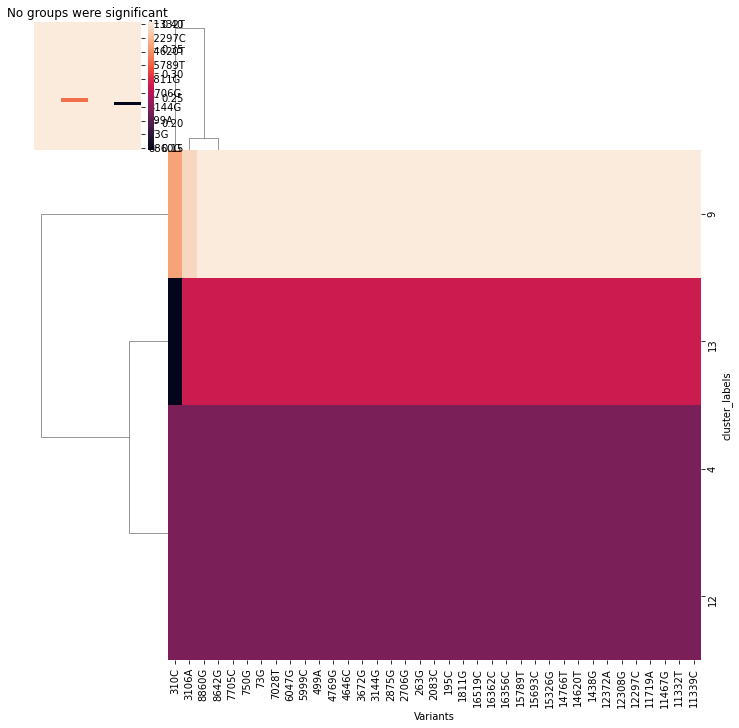

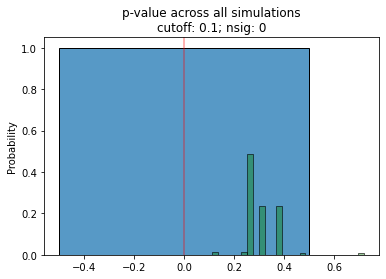

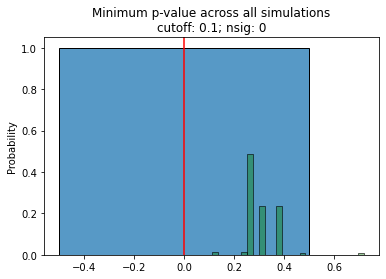

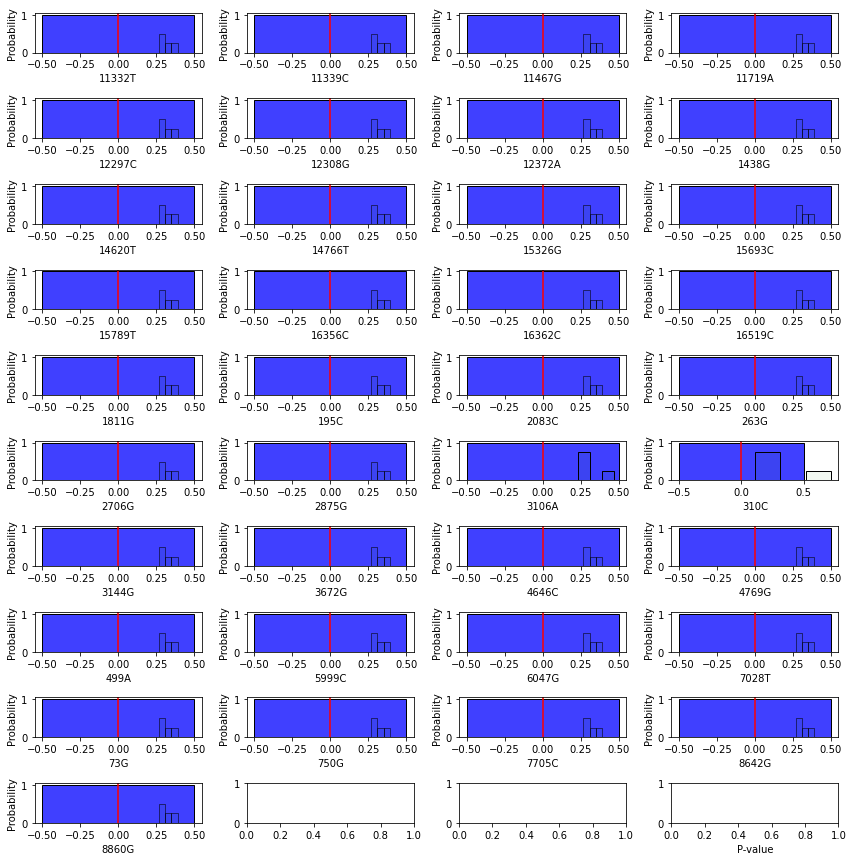

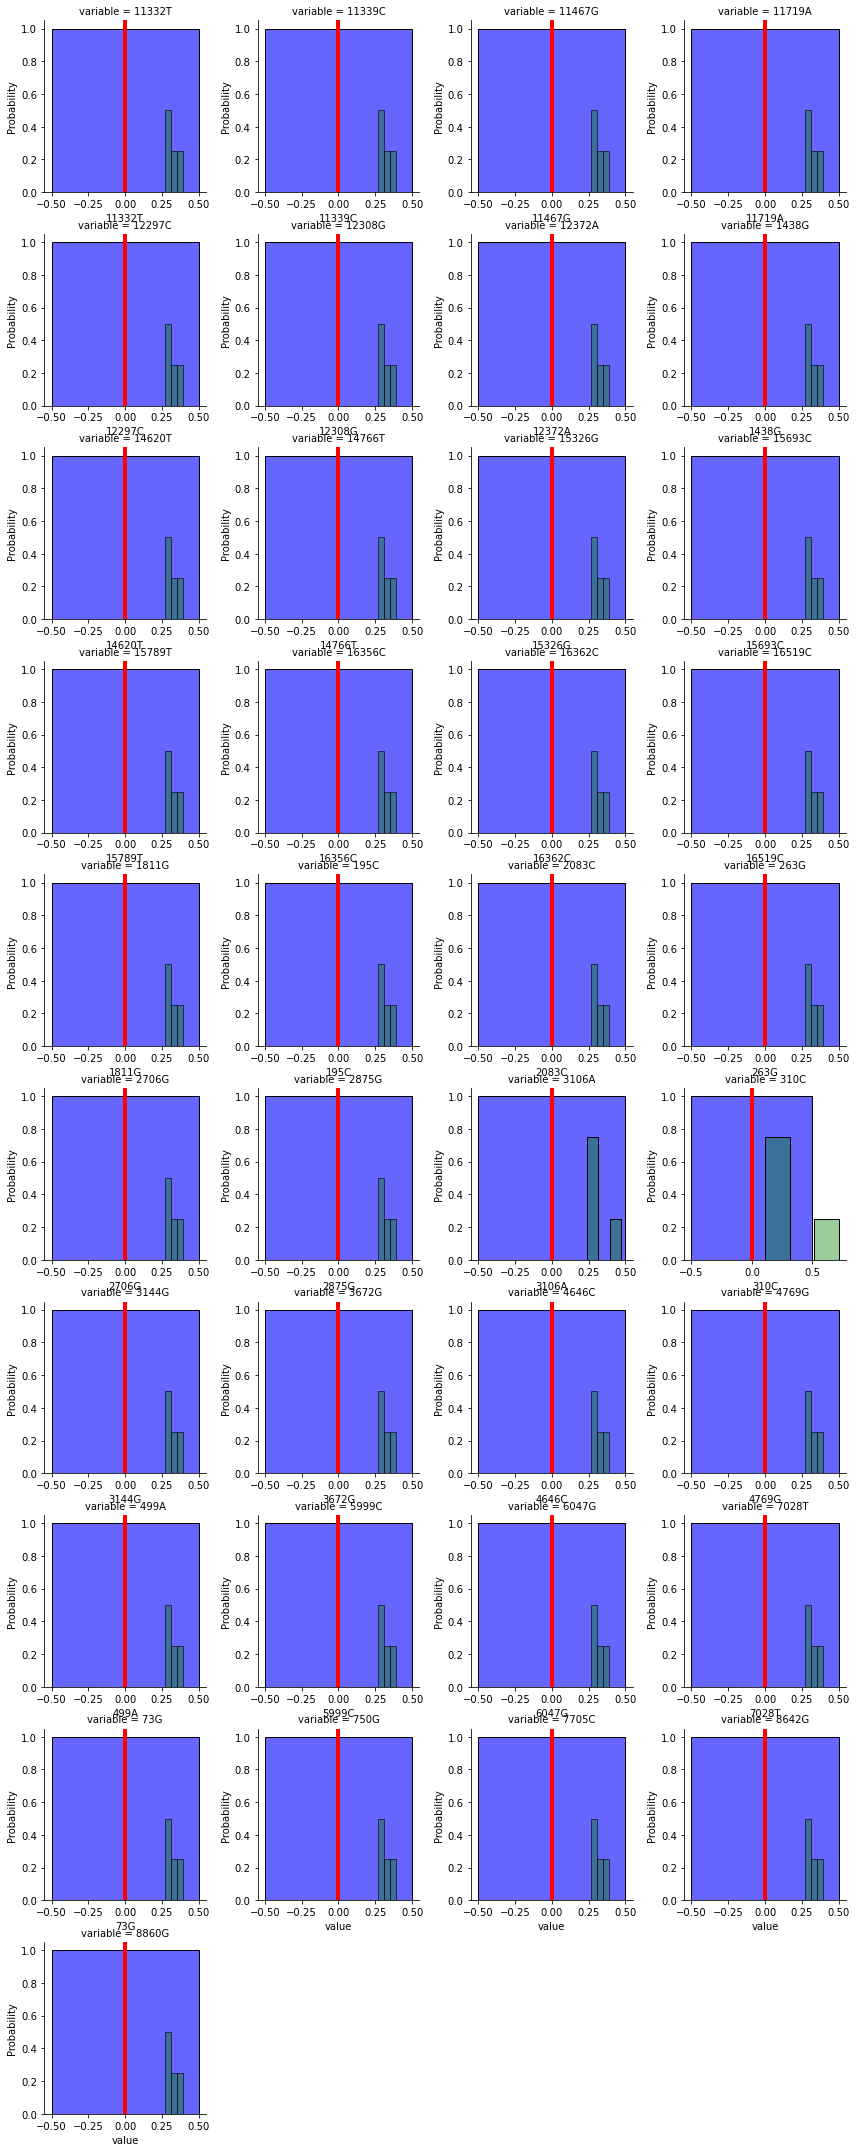

In [10]:
for d, val in lin_mt_ncells.groupby("donor"):
    #curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups = val
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)
    
    #cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes)
    
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=24)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    
# #     # plot just the counts
# #     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
# #     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
# #     plt.gca().set_title("log2 ncells")
# #     plt.savefig(join(curr_don_out, "ncells.png"))
    

In [ ]:
out_df

In [ ]:
#cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh, clones=curr_clones, atac_cl=curr_atac_cl)
#     clones, atac_cl = get_groups(curr_groupsr, curr_clones, curr_atac_cl, clone_col,
#                                  atac_col)

In [ ]:
# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)